In [37]:
from google.colab import drive
drive.mount('/content/drive/')
ROOT_DIR = '/content/drive/MyDrive/NLP course/NLP_Project'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## handy function

In [38]:
import time
import torch
import math
import os
import numpy as np



def print_current_time(output=''):
    import datetime
    import pytz
    current_time = datetime.datetime.now(pytz.timezone('Israel'))
    if output == '':
        print("The current time is: ")
    else:
        print(output)
    print(current_time)


def move_x_and_y_cpu( x, y):
        x = x.cpu()
        y = y.cpu()
        return (x,y)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (%s)' % (asMinutes(s), asMinutes(rs))


def calculate_accuracy(outputs, labels):
    pred = torch.argmax(outputs, dim=1)
    total = labels.size(0)
    correct = (pred == labels).sum().item()
    return correct, total


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def top_k_accuracy(outputs, labels, k):
    top_p, top_class = outputs.topk(k, dim=1)
    top_class = top_class.t()
    correct = top_class.eq(labels.view(1, -1).expand_as(top_class))
    total = labels.size(0)
    correct_k = correct.float().sum().item()
    return correct_k, total    







## tokenizing

In [39]:
!pip install transformers

In [40]:
from transformers import BertTokenizer
import torch

class Tokenizing:
    def __init__(self, df_songs):
        self.df_songs = df_songs
        self.max_embed_batch_len = 512
        self.songs_dict = dict()
        self.tokenizer = None
        self.create_tokenizer_instance()

    def create_tokenizer_instance(self):
        # Load the BERT tokenizer.
        print('Loading BERT tokenizer...')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    def tokenizing_batch(self, batch):
        """
        For every single song

        """

        # `encode_plus` will:
        #   (1) Tokenize the batch.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = self.tokenizer.encode_plus(
            batch,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=self.max_embed_batch_len,  # Pad & truncate all sentences.
            pad_to_max_length=True,
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='pt'  # Return pytorch tensors.
        )
        return encoded_dict

    def tokenize_each_song(self, tokenizing_path=None):
        """
        For all songs

        """
        print_current_time("starting tokenizing process")

        # if saved tokenizing
        if tokenizing_path is not None:
            self.songs_dict = torch.load(tokenizing_path)
            self.tokenizing_path = tokenizing_path
        else:
            for i in range(len(self.df_songs)):
                key = (self.df_songs.loc[i, "Artist"], self.df_songs.loc[i, "Song_name"])

                batch_lyrics = self.df_songs.loc[i, "Lyrics"]

                token_batch_lyrics = self.tokenizing_batch(batch_lyrics)
                token_batch_lyrics_data = token_batch_lyrics.data

                token_batch_lyrics_data['Lyrics'] = batch_lyrics

                self.songs_dict[key] = token_batch_lyrics_data


            


        print_current_time("finished tokenizing process")


## bertclassifer

In [41]:
from transformers import BertForSequenceClassification, BertConfig

class BERTClassifer():


  def __init__(self, args, device):


    # config = BertConfig.from_pretrained('bert-base-uncased')
    # config.num_labels = args.class_number
    # self.model = BertForSequenceClassification(config)

    # Load BertForSequenceClassification, the pretrained BERT model with a single
    # linear classification layer on top.
    self.model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",  # Use the 12-layer BERT model, with an uncased vocab.
        num_labels= args.class_number,  # The number of output labels
        # You can increase this for multi-class tasks.
        output_attentions=False,  # Whether the model returns attentions weights.
        output_hidden_states=False,  # Whether the model returns all hidden-states.
    )

    # Tell pytorch to run this model on the GPU.
    if device.type == 'cuda':
     self.model.cuda()


  # def embed_and_predict(self,token_songs_batch, device):
  #
  #    b_input_ids =token_songs_batch[0].to(device)
  #    b_input_mask =token_songs_batch[1].to(device)
  #    b_labels =token_songs_batch[2].to(device)
  #    b_labels =  b_labels.squeeze_()
  #
  #    loss, logits = self.model(b_input_ids,
  #                         token_type_ids=None,
  #                         attention_mask=b_input_mask,
  #                         labels=b_labels)
  #    return(logits)







## upload data to dataloader

In [42]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np




class upload_data_to_dataloader:

    def __init__(self, orig_songs_df, data, args,   tokenized_data = False ):

        self.labels = orig_songs_df['label'].values
        self.data = data
        self.args = args

        self.create_dataloader(tokenized_data)



    def create_dataloader(self,  tokenized_data):

       if  not tokenized_data:
            self.upload_emd_data()
       else:
            self.upload_tokenized_data()


    def upload_emd_data(self):

        train_features, test_features, train_labels, test_labels = train_test_split(self.data, self.labels,
                                                                                    test_size=self.args.test_ratio,
                                                                                    random_state=42)

        if self.args.validation_ratio > 0:
            train_features, val_features, train_labels, val_labels = train_test_split(train_features,
                                                                                      train_labels,
                                                                                      test_size=self.args.validation_ratio,
                                                                                      random_state=42
                                                                                      )
            val_dataset = TensorDataset(val_features, torch.from_numpy(val_labels))

            self.val_dataloader = DataLoader(val_dataset, batch_size=self.args.val_batch_size)

        tr_dataset = TensorDataset(train_features, torch.from_numpy(train_labels))

        self.tr_dataloader = DataLoader(tr_dataset, batch_size=self.args.tr_batch_size)

        test_dataset = TensorDataset(test_features, torch.from_numpy(test_labels))

        self.test_dataloader = DataLoader(test_dataset, batch_size=self.args.test_batch_size)



    def upload_tokenized_data(self):

        input_ids_data,  attention_mask_data  =   self.get_input_ids_att_maks_lists()

        train_input_id_data,  test_input_id_data,\
        train_attention_mask_data, test_attention_mask_data, \
        train_labels, test_labels = train_test_split(input_ids_data,  attention_mask_data, self.labels,test_size=self.args.test_ratio,   random_state=42)

        if self.args.validation_ratio > 0:
            train_input_id_data, val_input_id_data, \
            train_attention_mask_data, val_attention_mask_data, \
            train_labels, val_labels = train_test_split(train_input_id_data, train_attention_mask_data,  train_labels,
                                                         test_size=self.args.validation_ratio , random_state=42)

            val_dataset = TensorDataset(val_input_id_data, val_attention_mask_data ,torch.from_numpy(val_labels))

            self.val_dataloader = DataLoader(val_dataset, batch_size=self.args.val_batch_size)

        tr_dataset = TensorDataset(train_input_id_data, train_attention_mask_data ,torch.from_numpy(train_labels))

        self.tr_dataloader = DataLoader(tr_dataset, batch_size=self.args.tr_batch_size)

        test_dataset = TensorDataset(test_input_id_data, test_attention_mask_data ,torch.from_numpy(test_labels))

        self.test_dataloader =  DataLoader(test_dataset, batch_size=self.args.tr_batch_size)





    def get_input_ids_att_maks_lists(self):

        input_ids_data = torch.tensor([])
        attention_masks_data = torch.tensor([])

        for key, token_song in self.data.items():
                input_ids = token_song.get('input_ids')
                input_ids_data= torch.cat((input_ids_data,input_ids), dim = 0)

                attention_mask = token_song.get('attention_mask')
                attention_masks_data = torch.cat(( attention_masks_data, attention_mask), dim=0)


        return  input_ids_data, attention_masks_data








## train net

In [43]:
# import pandas as pd
from tqdm import tqdm
import torch
import time
import copy

# import pandas as pd
from tqdm import tqdm
import torch
import time
import copy


class TrainNet:
    def __init__(self, train_dataloader, net, optimizer, device, args, val_dataloader=None, save= False,  tr_bert_classifer = False,use_validation= True, k=2 ):

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.optimizer = optimizer
        self.net = net
        #self.best_net = None
        self.device = device
        self.save = save
        self.use_validation = use_validation
        self.num_epochs = args.num_epochs
        self.criterion = args.criterion
        self.early_stop_n = args.early_stop_n
        self.early_stop_acc_value = args.early_stop_acc_value
        self.tr_bert_classifer = tr_bert_classifer
        self.k = k

        self.epoch_before_early_stop = 0
        self.val_best_acc_epoch = 0
        self.val_acc_value_before_eraly_stop = 0.0
        self.val_loss_value_before_eraly_stop = 0.0
        self.tr_bert_classifer = tr_bert_classifer
        self.val_best_acc_value = 0.0
        self.val_best_loss_value = 100000.0




        self.train_loss = [None] *  self.num_epochs
        self.val_loss = [None] *  self.num_epochs

        self.train_acc = [None] *  self.num_epochs
        self.train_acc_k = [None] * self.num_epochs

        self.val_acc = [None] *  self.num_epochs
        self.val_acc_k = [None] * self.num_epochs




        self.train_net(tr_bert_classifer)

    def train_net(self, tr_bert_classifer= False):

        start = time.time()
        print_current_time("starting to train classifier net")
        epoch_total_train_loss = 0.0  # Reset every epoch

        for epoch in range( self.num_epochs):

            for tr_batch in tqdm(self.train_dataloader):

                self.net.train()
                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward
                loss, y_pred = self.forwad(tr_batch)

                # backward + optimize
                y_train = self.get_labels(tr_batch)
                loss = self.get_loss(loss, y_pred, y_train)
                loss.backward()
                self.optimizer.step()

                epoch_total_train_loss += loss.item()

            # train metrics
            self.train_loss[epoch] = epoch_total_train_loss / len(self.train_dataloader)
            epoch_total_train_loss = 0.0

            self.train_acc[epoch], self.train_acc_k[epoch], _ = self.evaluate(self.train_dataloader)

            if self.use_validation:
                # val metrics
                self.val_acc[epoch], self.val_acc_k[epoch], self.val_loss[epoch] = self.evaluate(self.val_dataloader, True)
                self.update_best_val_loss_acc(self.val_acc[epoch], self.val_loss[epoch], epoch )
                self.print_metrics(epoch, start, False )


                self.epoch_before_early_stop = epoch
                self.val_acc_value_before_eraly_stop =   self.val_acc[epoch]
                self.val_loss_value_before_eraly_stop =  self.val_loss[epoch]
                #early stop check
                if self.early_stopping_check(epoch):
                        break



            self.print_metrics(epoch, start)
            # print(f'Epoch #{epoch}:\n'
            #       f'Last batch Loss: {loss.item():.4f}\n'
            #       f'Train accuracy: {epoch_total_train_acc:.3f}\n'
            #       f'Test accuracy: {test_accuracy:.3f}\n'
            #       f'Time elapsed (remaining): {timeSince(start, (epoch+1) /  self.num_epochs)}')

            if self.save:
                save_model(self.net, epoch)



    def print_metrics(self, epoch, start, train=True):
        if epoch % 1 == 0 or epoch == self.num_epochs-1:
            print()
            print("******************************")

            if train:
                print(f'Epoch #{epoch + 1}:\n'
                      f'Train Loss: {self.train_loss[epoch]:.4f}\n'
                      f'Train accuracy: {self.train_acc[epoch]:.4f}\n'
                      f'Train k-accuracy: {self.train_acc_k[epoch]:.3f}\n'
                      f'Time elapsed (remaining): {timeSince(start, (epoch + 1) / self.num_epochs)}')

            else:

                print(f'Epoch #{epoch + 1}:\n'
                      f'Validation Loss: {self.val_loss[epoch]:.4f}\n'
                      f'Validation accuracy: {self.val_acc[epoch]:.4f}\n' 
                      f'Validation k-accuracy: {self.val_acc_k[epoch]:.3f}\n')

    def early_stopping_check(self, curr_epoch):
        if curr_epoch <  self.early_stop_n :
            return False



        for i in range(0,  self.early_stop_n):
            if self.val_acc[curr_epoch - i] - self.val_acc[curr_epoch - i - 1] >= self.early_stop_acc_value:
                return False


        print("made early stopping after epoch: ", curr_epoch)
        return True

    def evaluate(self, dataloader, val = False):

        total = 0.0
        correct = 0.0
        epoch_val_loss = 0.0
        correct_k = 0.0
        self.net.eval()

        with torch.no_grad():

            for val_batch in tqdm(dataloader):
                loss,outputs = self.forwad(val_batch)

                labels = self.get_labels(val_batch)
                current_correct, current_total = calculate_accuracy(outputs, labels)
                current_k_correct, _ = top_k_accuracy(outputs, labels, k=self.k)

                correct_k += current_k_correct
                correct += current_correct
                total += current_total

                if val:
                    val_loss = self.criterion(outputs, labels.long())
                    epoch_val_loss += val_loss.item()

        accuracy = correct / total
        k_accuracy = correct_k / total
        epoch_val_avg_loss = epoch_val_loss/len(self.train_dataloader)

        return accuracy, k_accuracy, epoch_val_avg_loss

    def forwad(self, batch):

        loss = -1

        if self.tr_bert_classifer:

            b_input_ids  =  batch[0].to(self.device).long()
            b_input_mask =  batch[1].to(self.device)
            b_labels     =  batch[2].to(self.device).long()
            #b_labels = b_labels.squeeze_()

            loss, y_pred = self.net(b_input_ids,
                                 token_type_ids=None,
                                 attention_mask=b_input_mask,
                                 labels=b_labels,
                                 return_dict=False
                                    )
        else:
            x_train = batch[0]
            x_train = x_train.to(self.device)

            y_pred = self.net(x_train)


        return loss, y_pred



    def get_labels(self, batch):

        if self.tr_bert_classifer:
            labels = batch[2].to(self.device)

        else:
            labels = batch[1].to(self.device)

        labels = labels.squeeze_()

        return labels

    def get_loss(self, loss, y_pred, y_train):

        if self.tr_bert_classifer:
            return loss

        else:
            loss = self.criterion(y_pred, y_train.long())
            return loss

    def update_best_val_loss_acc(self,  last_epoch_acc_value,  last_epoch_loss_value, epoch):

        if last_epoch_acc_value > self.val_best_acc_value:
            self.val_best_acc_value= last_epoch_acc_value
            self.val_best_acc_epoch = epoch
            #self.best_net = copy.deepcopy(self.net)

        if last_epoch_loss_value < self.val_best_loss_value:
            self.val_best_loss_value =  last_epoch_loss_value


  


























##Preproccess Data

In [44]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


class PreprocessData:

    def __init__(self, song_csv_path, max_word):
        self.df_songs = pd.read_csv(song_csv_path)
        self.filtered_df_songs = pd.DataFrame()
        self.max_words = max_word

        self.add_labels()
        self.delete_songs_more_n_words(self.max_words)

    def add_labels(self):
        labelencoder = LabelEncoder()
        self.df_songs["label"]=labelencoder.fit_transform(self.df_songs["Artist"])

    def delete_songs_more_n_words(self, max_n_words):
        self.df_songs['words_num'] =   self.df_songs.Lyrics.apply(lambda x: len(str(x).replace("\n"," " ).split(' ')))
        # from collections import Counter
        # self.df_songs['words_num'] =self.df_songs['lyrics'].apply(lambda x: Counter(" ".join(x).split(" ")).items())
        self.filtered_df_songs =  self.df_songs[self.df_songs['words_num'] <= max_n_words].reset_index()


## args

In [45]:
import torch.nn.functional


class args:

  def __init__(self):

    #NN architecture args
    self.input_size = 768
    self.class_number= 5
    self.p1= 0.5
    self.p2 = 0.25
    self.fc1_output_size = 256
    self.fc2_output_size = 64


    # Train-test split args
    self.validation_ratio = 0.2
    self.test_ratio = 0.2

    # NN training args
    self.tr_batch_size =  8
    self.val_batch_size = 8
    self.num_epochs = 20

    # NN back propagation arg0s
    self.lr = 2e-5
    self.weight_decay= 0.001
    self.criterion = torch.nn.CrossEntropyLoss()

    # NN early stopping args
    self.early_stop_n = 3
    self.early_stop_acc_value = 0




## Plots

In [46]:
from matplotlib import pyplot as plt
from datetime import datetime
import os
import numpy as np
FIGURES_DIR = os.path.join(ROOT_DIR, 'figures')

def plot_accuracies(train_accs, test_accs, model_name):
    current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.figure(figsize=(20, 8))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    # plt.tight_layout()
    plt.plot(train_accs, label='train')
    plt.plot(test_accs, label='validation')
    plt.title(f'{model_name} accuracy')
    plt.xticks(range(len(train_accs)), range(1, len(train_accs) + 1))
    plt.yticks(np.around(np.linspace(0.0, 1.0, num=11), decimals=1))
    plt.legend()
    # plt.grid(True)
    plt.savefig(os.path.join(FIGURES_DIR, f'{model_name}_accuracy_{current_time}.png'))
    plt.show()


def plot_loss(train_loss, val_loss, model_name):
    current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.figure(figsize=(20, 8))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    # plt.tight_layout()
    plt.plot(train_loss,  label='training')
    plt.plot(val_loss,   label='validation')
    plt.legend()

    plt.title(f'{model_name} loss')
    plt.xticks(range(len(train_loss)), range(1, len(train_loss) + 1))
    # plt.yticks(np.around(np.linspace(0.0, 1.0, num=11), decimals=1))
    # plt.grid(True)
    plt.savefig(os.path.join(FIGURES_DIR, f'{model_name}_loss_{current_time}.png'))
    plt.show()


## MAIN

cuda
Loading BERT tokenizer...
starting tokenizing process
2021-04-16 10:15:11.536126+03:00
finished tokenizing process
2021-04-16 10:15:11.729036+03:00


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

starting to train classifier net
2021-04-16 10:15:18.014301+03:00



100%|██████████| 115/115 [01:41<00:00,  1.13it/s]

100%|██████████| 115/115 [00:36<00:00,  3.12it/s]

100%|██████████| 29/29 [00:09<00:00,  3.17it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #1:
Validation Loss: 0.2025
Validation accuracy: 0.6725
Validation k-accuracy: 0.908


******************************
Epoch #1:
Train Loss: 1.0469
Train accuracy: 0.6863
Train k-accuracy: 0.905
Time elapsed (remaining): 2m 27s (46m 41s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.16it/s]

100%|██████████| 29/29 [00:09<00:00,  3.18it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #2:
Validation Loss: 0.1720
Validation accuracy: 0.6987
Validation k-accuracy: 0.908


******************************
Epoch #2:
Train Loss: 0.6455
Train accuracy: 0.8896
Train k-accuracy: 0.981
Time elapsed (remaining): 4m 53s (44m 1s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.15it/s]

100%|██████████| 29/29 [00:09<00:00,  3.17it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #3:
Validation Loss: 0.1696
Validation accuracy: 0.7380
Validation k-accuracy: 0.913


******************************
Epoch #3:
Train Loss: 0.3552
Train accuracy: 0.9224
Train k-accuracy: 0.993
Time elapsed (remaining): 7m 19s (41m 32s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.14it/s]

100%|██████████| 29/29 [00:09<00:00,  3.16it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #4:
Validation Loss: 0.2027
Validation accuracy: 0.7467
Validation k-accuracy: 0.934


******************************
Epoch #4:
Train Loss: 0.2218
Train accuracy: 0.9027
Train k-accuracy: 0.990
Time elapsed (remaining): 9m 46s (39m 5s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.15it/s]

100%|██████████| 29/29 [00:09<00:00,  3.18it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #5:
Validation Loss: 0.2477
Validation accuracy: 0.7249
Validation k-accuracy: 0.921


******************************
Epoch #5:
Train Loss: 0.1692
Train accuracy: 0.9672
Train k-accuracy: 0.997
Time elapsed (remaining): 12m 13s (36m 39s)



100%|██████████| 115/115 [01:41<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.15it/s]

100%|██████████| 29/29 [00:09<00:00,  3.17it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #6:
Validation Loss: 0.2133
Validation accuracy: 0.7467
Validation k-accuracy: 0.939


******************************
Epoch #6:
Train Loss: 0.1176
Train accuracy: 0.9934
Train k-accuracy: 1.000
Time elapsed (remaining): 14m 39s (34m 12s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.15it/s]

100%|██████████| 29/29 [00:09<00:00,  3.19it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #7:
Validation Loss: 0.2571
Validation accuracy: 0.7642
Validation k-accuracy: 0.934


******************************
Epoch #7:
Train Loss: 0.0301
Train accuracy: 0.9716
Train k-accuracy: 1.000
Time elapsed (remaining): 17m 6s (31m 45s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.15it/s]

100%|██████████| 29/29 [00:09<00:00,  3.18it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #8:
Validation Loss: 0.2386
Validation accuracy: 0.7860
Validation k-accuracy: 0.926


******************************
Epoch #8:
Train Loss: 0.0382
Train accuracy: 0.9934
Train k-accuracy: 1.000
Time elapsed (remaining): 19m 32s (29m 19s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.14it/s]

100%|██████████| 29/29 [00:09<00:00,  3.16it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #9:
Validation Loss: 0.3438
Validation accuracy: 0.6900
Validation k-accuracy: 0.926


******************************
Epoch #9:
Train Loss: 0.0411
Train accuracy: 0.9869
Train k-accuracy: 1.000
Time elapsed (remaining): 21m 59s (26m 52s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.16it/s]

100%|██████████| 29/29 [00:09<00:00,  3.18it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #10:
Validation Loss: 0.3001
Validation accuracy: 0.7467
Validation k-accuracy: 0.917


******************************
Epoch #10:
Train Loss: 0.0218
Train accuracy: 0.9956
Train k-accuracy: 1.000
Time elapsed (remaining): 24m 25s (24m 25s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.16it/s]

100%|██████████| 29/29 [00:09<00:00,  3.18it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #11:
Validation Loss: 0.2421
Validation accuracy: 0.7860
Validation k-accuracy: 0.913


******************************
Epoch #11:
Train Loss: 0.0309
Train accuracy: 1.0000
Train k-accuracy: 1.000
Time elapsed (remaining): 26m 51s (21m 58s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.14it/s]

100%|██████████| 29/29 [00:09<00:00,  3.16it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #12:
Validation Loss: 0.2460
Validation accuracy: 0.7948
Validation k-accuracy: 0.926


******************************
Epoch #12:
Train Loss: 0.0042
Train accuracy: 1.0000
Train k-accuracy: 1.000
Time elapsed (remaining): 29m 18s (19m 32s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.15it/s]

100%|██████████| 29/29 [00:09<00:00,  3.16it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #13:
Validation Loss: 0.2532
Validation accuracy: 0.7948
Validation k-accuracy: 0.926


******************************
Epoch #13:
Train Loss: 0.0030
Train accuracy: 1.0000
Train k-accuracy: 1.000
Time elapsed (remaining): 31m 44s (17m 5s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.14it/s]

100%|██████████| 29/29 [00:09<00:00,  3.17it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #14:
Validation Loss: 0.2584
Validation accuracy: 0.7904
Validation k-accuracy: 0.930


******************************
Epoch #14:
Train Loss: 0.0026
Train accuracy: 1.0000
Train k-accuracy: 1.000
Time elapsed (remaining): 34m 11s (14m 39s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.15it/s]

100%|██████████| 29/29 [00:09<00:00,  3.17it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #15:
Validation Loss: 0.2659
Validation accuracy: 0.7860
Validation k-accuracy: 0.930


******************************
Epoch #15:
Train Loss: 0.0022
Train accuracy: 1.0000
Train k-accuracy: 1.000
Time elapsed (remaining): 36m 37s (12m 12s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.14it/s]

100%|██████████| 29/29 [00:09<00:00,  3.17it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #16:
Validation Loss: 0.2762
Validation accuracy: 0.7904
Validation k-accuracy: 0.930


******************************
Epoch #16:
Train Loss: 0.0021
Train accuracy: 1.0000
Train k-accuracy: 1.000
Time elapsed (remaining): 39m 4s (9m 46s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.14it/s]

100%|██████████| 29/29 [00:09<00:00,  3.16it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #17:
Validation Loss: 0.2823
Validation accuracy: 0.7904
Validation k-accuracy: 0.930


******************************
Epoch #17:
Train Loss: 0.0018
Train accuracy: 1.0000
Train k-accuracy: 1.000
Time elapsed (remaining): 41m 31s (7m 19s)



100%|██████████| 115/115 [01:41<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.14it/s]

100%|██████████| 29/29 [00:09<00:00,  3.16it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #18:
Validation Loss: 0.2879
Validation accuracy: 0.7948
Validation k-accuracy: 0.926


******************************
Epoch #18:
Train Loss: 0.0017
Train accuracy: 1.0000
Train k-accuracy: 1.000
Time elapsed (remaining): 43m 58s (4m 53s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.14it/s]

100%|██████████| 29/29 [00:09<00:00,  3.17it/s]

  0%|          | 0/115 [00:00<?, ?it/s]


******************************
Epoch #19:
Validation Loss: 0.2989
Validation accuracy: 0.7948
Validation k-accuracy: 0.921


******************************
Epoch #19:
Train Loss: 0.0016
Train accuracy: 1.0000
Train k-accuracy: 1.000
Time elapsed (remaining): 46m 24s (2m 26s)



100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

100%|██████████| 115/115 [00:36<00:00,  3.16it/s]

100%|██████████| 29/29 [00:09<00:00,  3.19it/s]



******************************
Epoch #20:
Validation Loss: 0.3019
Validation accuracy: 0.7904
Validation k-accuracy: 0.921


******************************
Epoch #20:
Train Loss: 0.0014
Train accuracy: 1.0000
Train k-accuracy: 1.000
Time elapsed (remaining): 48m 51s (0m 0s)
best validation accuracy was:  0.7948 after epoch number:  11


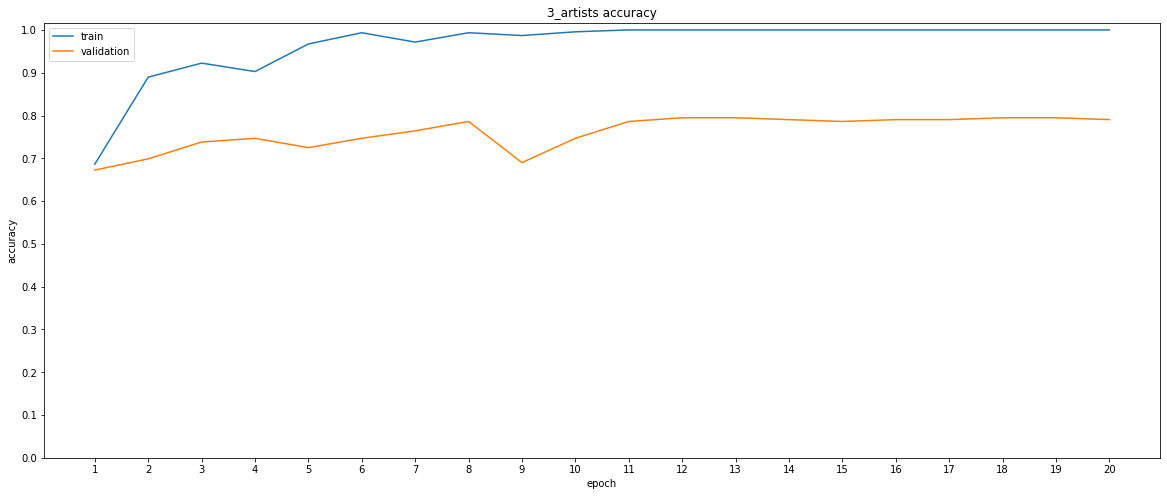

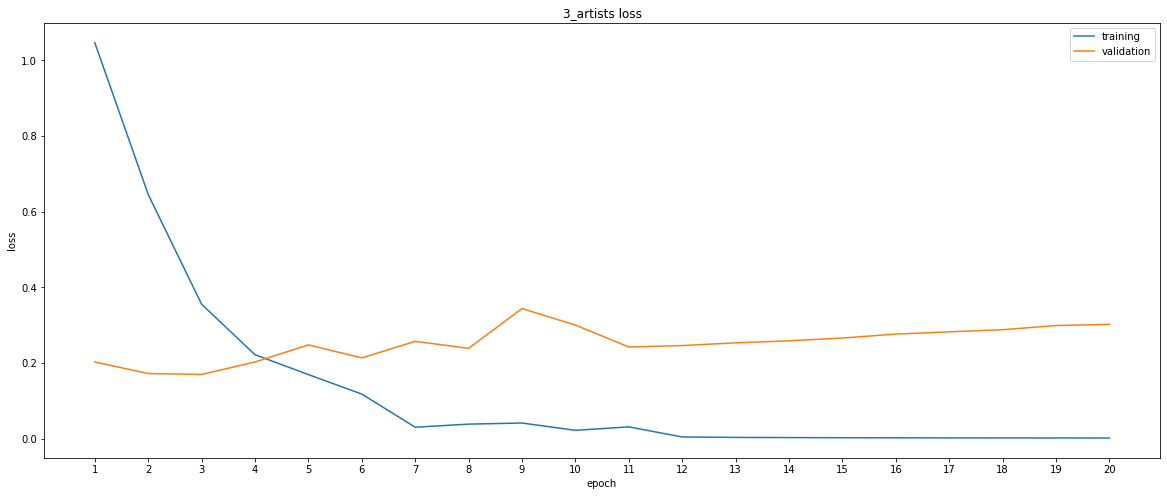

In [47]:
import torch
import os
from torch import optim
import pickle
DATA_DIR = os.path.join(ROOT_DIR, 'data')
tr_bert_classifer =  True

# set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#args
args = args()


# pre-process data
data_file = os.path.join(DATA_DIR, 'just_3_artist.csv')
songs_df = pickle.load(open(os.path.join(DATA_DIR, 'just_3_art.pkl'), "rb")) # PreprocessData(data_file, 512)

# tokenize songs
tokenizing_path = os.path.join(DATA_DIR, "songs_3_artists_token.pt")
song_token = Tokenizing(df_songs= songs_df.filtered_df_songs )
song_token.tokenize_each_song(tokenizing_path)

if tokenizing_path is None:
    torch.save(song_token.songs_dict, DATA_DIR + "\\songs_3_artists_token.pt")

if not tr_bert_classifer:
    # song embeddings
    embedding_path = os.path.join(DATA_DIR, "embedding_songs_five_artists.pt")
    embedding_songs = Embedding(tokenizing_data=song_token.songs_dict, device=device, embedding_path= embedding_path)
    embedding_songs.data_embedding()

    if embedding_songs.embedding_path is None:
        torch.save(embedding_songs.songs_features,  DATA_DIR + "\\embedding_songs_five_artists.pt" )

    # create dataloader from embeddings
    embedding_dataloaders = upload_data_to_dataloader(song_token.df_songs, embedding_songs.songs_features, args= args)

else:
    embedding_dataloaders = upload_data_to_dataloader(song_token.df_songs, song_token.songs_dict, args=args, tokenized_data= True)

# train classification net
if tr_bert_classifer:

    bert_classifer = BERTClassifer(args, device)
    untrained_net = bert_classifer.model


else:
    untrained_net = ClassificationNet(args, input_size=args.input_size).to(device)

untrained_net_final = copy.deepcopy(untrained_net)


LR = args.lr
WEIGHT_DECAY = args.weight_decay

if WEIGHT_DECAY > 0:
    adam_optimizer = optim.Adam(untrained_net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
else:
    adam_optimizer = optim.Adam(untrained_net.parameters(), lr=LR)


trained_net = TrainNet(train_dataloader=embedding_dataloaders.tr_dataloader, optimizer=adam_optimizer,
                                      device=device, net=    untrained_net,
                                      val_dataloader=embedding_dataloaders.val_dataloader,
                                      args= args, tr_bert_classifer = tr_bert_classifer, k=2)

model_result = {'loss': trained_net.train_loss, 'train_acc': trained_net.train_acc, 'test_acc': trained_net.val_acc}
with open(os.path.join(DATA_DIR, 'bert_with_classifer.pkl'), 'wb') as f:
    pickle.dump(model_result, f)


print("best validation accuracy was: ", round(trained_net.val_best_acc_value, 4), "after epoch number: ", trained_net.val_best_acc_epoch)


#plot figures
plot_accuracies(trained_net.train_acc, trained_net.val_acc, '3_artists')
plot_loss(trained_net.train_loss, trained_net.val_loss, '3_artists')








In [48]:




print("training final net")


args.validation_ratio = 0
args.early_stop_n = 1000000
args.num_epochs = trained_net.val_best_acc_epoch

del trained_net



if not tr_bert_classifer:
    embedding_dataloaders_without_val = upload_data_to_dataloader(song_token.df_songs, embedding_songs.songs_features, args= args)


else:
    embedding_dataloaders_without_val = upload_data_to_dataloader(song_token.df_songs, song_token.songs_dict, args=args, tokenized_data= True)


if WEIGHT_DECAY > 0:
    adam_optimizer = optim.Adam(untrained_net_final.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
else:
    adam_optimizer = optim.Adam(untrained_net_final.parameters(), lr=LR)



final_net = TrainNet(train_dataloader= embedding_dataloaders_without_val.tr_dataloader, optimizer=adam_optimizer,
                                      device=device, net= untrained_net_final,
                                      val_dataloader=embedding_dataloaders_without_val.test_dataloader,
                                      args= args, tr_bert_classifer = tr_bert_classifer, k=3)





training final net



  0%|          | 0/143 [00:00<?, ?it/s]

starting to train classifier net
2021-04-16 11:04:10.905066+03:00



100%|██████████| 143/143 [02:05<00:00,  1.14it/s]

100%|██████████| 143/143 [00:45<00:00,  3.13it/s]

100%|██████████| 36/36 [00:11<00:00,  3.12it/s]

  0%|          | 0/143 [00:00<?, ?it/s]


******************************
Epoch #1:
Validation Loss: 0.1977
Validation accuracy: 0.6551
Validation k-accuracy: 1.000


******************************
Epoch #1:
Train Loss: 0.9831
Train accuracy: 0.6993
Train k-accuracy: 1.000
Time elapsed (remaining): 3m 3s (30m 31s)



100%|██████████| 143/143 [02:06<00:00,  1.13it/s]

100%|██████████| 143/143 [00:45<00:00,  3.13it/s]

100%|██████████| 36/36 [00:11<00:00,  3.14it/s]

  0%|          | 0/143 [00:00<?, ?it/s]


******************************
Epoch #2:
Validation Loss: 0.1435
Validation accuracy: 0.7666
Validation k-accuracy: 1.000


******************************
Epoch #2:
Train Loss: 0.5518
Train accuracy: 0.9423
Train k-accuracy: 1.000
Time elapsed (remaining): 6m 6s (27m 29s)



100%|██████████| 143/143 [02:05<00:00,  1.14it/s]

100%|██████████| 143/143 [00:45<00:00,  3.13it/s]

100%|██████████| 36/36 [00:11<00:00,  3.14it/s]

  0%|          | 0/143 [00:00<?, ?it/s]


******************************
Epoch #3:
Validation Loss: 0.1705
Validation accuracy: 0.7735
Validation k-accuracy: 0.993


******************************
Epoch #3:
Train Loss: 0.2743
Train accuracy: 0.9773
Train k-accuracy: 1.000
Time elapsed (remaining): 9m 9s (24m 25s)



100%|██████████| 143/143 [02:06<00:00,  1.13it/s]

100%|██████████| 143/143 [00:45<00:00,  3.12it/s]

100%|██████████| 36/36 [00:11<00:00,  3.14it/s]

  0%|          | 0/143 [00:00<?, ?it/s]


******************************
Epoch #4:
Validation Loss: 0.2058
Validation accuracy: 0.7596
Validation k-accuracy: 1.000


******************************
Epoch #4:
Train Loss: 0.1733
Train accuracy: 0.9729
Train k-accuracy: 1.000
Time elapsed (remaining): 12m 13s (21m 23s)



100%|██████████| 143/143 [02:05<00:00,  1.14it/s]

100%|██████████| 143/143 [00:45<00:00,  3.12it/s]

100%|██████████| 36/36 [00:11<00:00,  3.13it/s]

  0%|          | 0/143 [00:00<?, ?it/s]


******************************
Epoch #5:
Validation Loss: 0.1904
Validation accuracy: 0.7456
Validation k-accuracy: 1.000


******************************
Epoch #5:
Train Loss: 0.1267
Train accuracy: 0.9607
Train k-accuracy: 1.000
Time elapsed (remaining): 15m 16s (18m 19s)



100%|██████████| 143/143 [02:06<00:00,  1.13it/s]

100%|██████████| 143/143 [00:45<00:00,  3.13it/s]

100%|██████████| 36/36 [00:11<00:00,  3.15it/s]

  0%|          | 0/143 [00:00<?, ?it/s]


******************************
Epoch #6:
Validation Loss: 0.2189
Validation accuracy: 0.7770
Validation k-accuracy: 1.000


******************************
Epoch #6:
Train Loss: 0.1014
Train accuracy: 0.9799
Train k-accuracy: 1.000
Time elapsed (remaining): 18m 19s (15m 16s)



100%|██████████| 143/143 [02:06<00:00,  1.13it/s]

100%|██████████| 143/143 [00:45<00:00,  3.13it/s]

100%|██████████| 36/36 [00:11<00:00,  3.14it/s]

  0%|          | 0/143 [00:00<?, ?it/s]


******************************
Epoch #7:
Validation Loss: 0.3059
Validation accuracy: 0.7387
Validation k-accuracy: 0.986


******************************
Epoch #7:
Train Loss: 0.0481
Train accuracy: 0.9196
Train k-accuracy: 1.000
Time elapsed (remaining): 21m 23s (12m 13s)



100%|██████████| 143/143 [02:05<00:00,  1.14it/s]

100%|██████████| 143/143 [00:45<00:00,  3.12it/s]

100%|██████████| 36/36 [00:11<00:00,  3.12it/s]

  0%|          | 0/143 [00:00<?, ?it/s]


******************************
Epoch #8:
Validation Loss: 0.2360
Validation accuracy: 0.7840
Validation k-accuracy: 0.990


******************************
Epoch #8:
Train Loss: 0.0211
Train accuracy: 0.9991
Train k-accuracy: 1.000
Time elapsed (remaining): 24m 26s (9m 9s)



100%|██████████| 143/143 [02:05<00:00,  1.14it/s]

100%|██████████| 143/143 [00:45<00:00,  3.13it/s]

100%|██████████| 36/36 [00:11<00:00,  3.13it/s]

  0%|          | 0/143 [00:00<?, ?it/s]


******************************
Epoch #9:
Validation Loss: 0.2882
Validation accuracy: 0.7666
Validation k-accuracy: 0.986


******************************
Epoch #9:
Train Loss: 0.0131
Train accuracy: 0.9983
Train k-accuracy: 1.000
Time elapsed (remaining): 27m 29s (6m 6s)



100%|██████████| 143/143 [02:06<00:00,  1.13it/s]

100%|██████████| 143/143 [00:45<00:00,  3.13it/s]

100%|██████████| 36/36 [00:11<00:00,  3.13it/s]

  0%|          | 0/143 [00:00<?, ?it/s]


******************************
Epoch #10:
Validation Loss: 0.2532
Validation accuracy: 0.7700
Validation k-accuracy: 0.993


******************************
Epoch #10:
Train Loss: 0.0046
Train accuracy: 1.0000
Train k-accuracy: 1.000
Time elapsed (remaining): 30m 33s (3m 3s)



100%|██████████| 143/143 [02:06<00:00,  1.13it/s]

100%|██████████| 143/143 [00:45<00:00,  3.14it/s]

100%|██████████| 36/36 [00:11<00:00,  3.13it/s]


******************************
Epoch #11:
Validation Loss: 0.2790
Validation accuracy: 0.7700
Validation k-accuracy: 0.990


******************************
Epoch #11:
Train Loss: 0.0034
Train accuracy: 1.0000
Train k-accuracy: 1.000
Time elapsed (remaining): 33m 36s (0m 0s)
